In [1]:
import numpy as np

%matplotlib inline
import matplotlib.pyplot as plt

from tqdm import tqdm_notebook as tqdm

import tensorflow as tf
from craynn import *

from craynn import viz

W0814 19:29:41.808193 140331048099968 deprecation_wrapper.py:119] From /home/mborisyak/dev/craynn/craynn/parameters/common.py:27: The name tf.random_normal is deprecated. Please use tf.random.normal instead.

W0814 19:29:41.809285 140331048099968 deprecation_wrapper.py:119] From /home/mborisyak/dev/craynn/craynn/parameters/common.py:29: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W0814 19:29:41.839969 140331048099968 deprecation_wrapper.py:119] From /home/mborisyak/dev/craynn/craynn/updates/gradient/tf_updates.py:31: The name tf.train.GradientDescentOptimizer is deprecated. Please use tf.compat.v1.train.GradientDescentOptimizer instead.

W0814 19:29:41.841471 140331048099968 deprecation_wrapper.py:119] From /home/mborisyak/dev/craynn/craynn/updates/gradient/tf_updates.py:39: The name tf.train.MomentumOptimizer is deprecated. Please use tf.compat.v1.train.MomentumOptimizer instead.

W0814 19:29:41.842905 140331048099968 deprecation_wrapper.py:119] Fr

In [2]:
session = get_cpu_session()

W0814 19:29:41.868999 140331048099968 deprecation_wrapper.py:119] From /home/mborisyak/dev/craynn/craynn/utils/tf_utils.py:16: The name tf.ConfigProto is deprecated. Please use tf.compat.v1.ConfigProto instead.

W0814 19:29:41.870332 140331048099968 deprecation_wrapper.py:119] From /home/mborisyak/dev/craynn/craynn/utils/tf_utils.py:21: The name tf.Session is deprecated. Please use tf.compat.v1.Session instead.



In [3]:
nn = net((None, 2))(
    dense(256,),
    dense(32, ),
    dense(1, activation=linear()),
    flatten(1)
)

W0814 19:29:41.987185 140331048099968 deprecation_wrapper.py:119] From /home/mborisyak/dev/craynn/craynn/utils/tf_utils.py:102: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.



In [4]:
data_pos = np.random.normal(size=(128, 2)).astype('float32')
data_neg = (np.random.normal(size=(16, 2)) + np.array([1, 2])[None, :]).astype('float32')

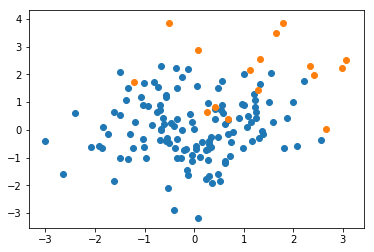

In [5]:
plt.scatter(data_pos[:, 0], data_pos[:, 1])
plt.scatter(data_neg[:, 0], data_neg[:, 1])

In [6]:
X_pos = tf.Variable(initial_value=data_pos, dtype='float32')
X_neg = tf.Variable(initial_value=data_neg, dtype='float32')

In [7]:
p_pos, = nn(X_pos)
p_neg, = nn(X_neg)

In [8]:
session.run(nn.reset())
session.run([X_pos.initializer, X_neg.initializer])

[None, None]

In [9]:
xs = np.linspace(-4, 4, num=100)

X_g, Y_g = np.meshgrid(xs, xs)

grid = np.vstack([X_g.ravel(), Y_g.ravel()]).T

### Brute-force

In [10]:
X_pseudo = tf.random_uniform(shape=(128, 2), minval=-6, maxval=6, dtype='float32')

In [11]:
p_pseudo, = nn(X_pseudo)

In [12]:
loss_pos = 128 / (128 + 16) * tf.reduce_mean(tf.nn.softplus(-p_pos))
loss_neg = 16 / (128 + 16) * tf.reduce_mean(tf.nn.softplus(p_neg))
loss_pseudo = 0.01 * tf.reduce_mean(tf.nn.softplus(p_pseudo))

In [13]:
loss = loss_pos + loss_neg# + loss_pseudo

In [14]:
opt = tf_updates.adam(learning_rate=2e-4)(loss, nn.variables())

In [15]:
session.run(opt.reset())

In [16]:
for _ in tqdm(range(16 * 1024)):
    session.run(opt.updates())

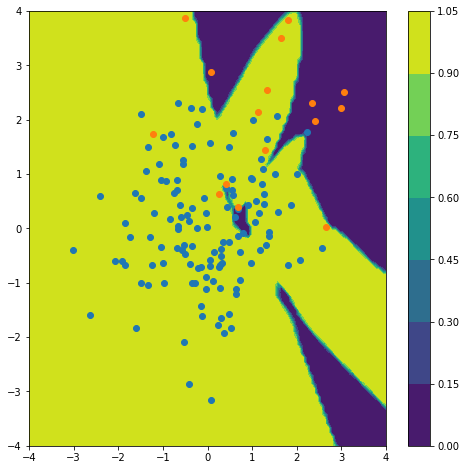

In [17]:
grid_p, = nn.eval(session, grid)

from scipy.special import expit

plt.figure(figsize=(8, 8))
plt.contourf(xs, xs, expit(grid_p.reshape(xs.shape[0], xs.shape[0])).T)
plt.colorbar()

plt.scatter(data_pos[:, 0], data_pos[:, 1])
plt.scatter(data_neg[:, 0], data_neg[:, 1])

###  Energy

In [18]:
from ope.models.utils import rmsprop_chain

In [19]:
chain = rmsprop_chain(num_steps=4, step_size=1e-1, noise=1)(nn, 128, initial=None, bounding_box=None)

In [20]:
session.run(chain.reset())

[None, None]

In [21]:
data_pseudo = session.run(chain())

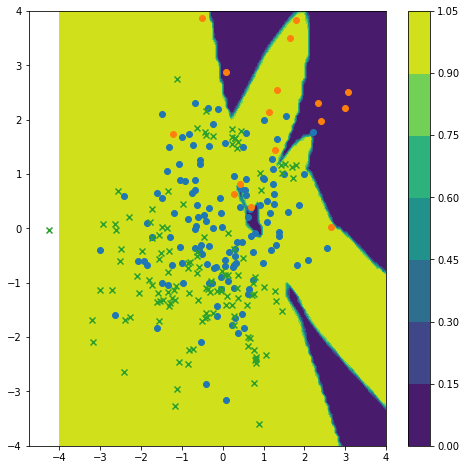

In [22]:
from scipy.special import expit

plt.figure(figsize=(8, 8))
plt.contourf(xs, xs, expit(grid_p.reshape(xs.shape[0], xs.shape[0])).T)
plt.colorbar()

plt.scatter(data_pos[:, 0], data_pos[:, 1])
plt.scatter(data_neg[:, 0], data_neg[:, 1])

plt.scatter(data_pseudo[:, 0], data_pseudo[:, 1], marker='x')

In [23]:
X_pseudo = chain()

In [24]:
p_pseudo, = nn(X_pseudo)

In [25]:
loss_pseudo = 0.01 * tf.reduce_mean(p_pseudo)

In [26]:
loss = loss_pos + loss_neg + loss_pseudo

In [27]:
opt = tf_updates.adam(learning_rate=2e-4)(loss, nn.variables())

In [28]:
session.run(opt.reset())

In [29]:
for _ in tqdm(range(16 * 1024)):
    session.run([opt.updates(), chain.updates()])

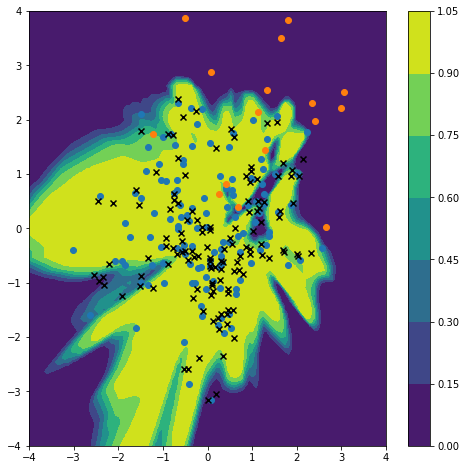

In [30]:
grid_p, = nn.eval(session, grid)

from scipy.special import expit

data_pseudo = session.run(chain())

plt.figure(figsize=(8, 8))
plt.contourf(xs, xs, expit(grid_p.reshape(xs.shape[0], xs.shape[0])).T)
plt.colorbar()

plt.scatter(data_pos[:, 0], data_pos[:, 1])
plt.scatter(data_neg[:, 0], data_neg[:, 1])
plt.scatter(data_pseudo[:, 0], data_pseudo[:, 1], marker='x', color='black')